### Interference of seagoing and dredging vessels

This notebook focuses on the interference of a single dredging vessel and a single seagoing vessel when trying to serve a berth location. The main objective of this problem is to monitor the interferences of both seagoing and dredging operations simultaneously. This monitoring process can help researchers and practitioners to
1. Identify the key perfromance indicators of seagoing operation (e.g. ship turnaround time, waiting time in anchorage area, etc.)
2. Quantify trade-offs (cost, emission, energy consumption, etc.) when selecting optimal port maintenance strategies.

The simulation proposed in this notebook is based on running the following activities.
* Dredging vessel does a single run activity which is performed until the total amount of soil is dredged from the berth location
* Seagoing vessel's subprocesses include sailing full, unloading cargo in the berth location, and sailing empty

The purpose of developing this notebook is to visualize that the berth location can serve one vessel at the same time and when one of the seagoing/dredging vessels are serving the berth, the other one should wait for the berth to get empty. The output shows us how much the seagoing vessel waits for the dredging vessel before entering the berth location and minimizing this waiting time can be the next steps.

The following steps are proposed to develop this notebook.

#### 0. Import libraries

In [1]:
import networkx as nx  
import shapely.geometry
import pyproj


import datetime as dt
import time
import simpy
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import opentnsim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

#### 1. Initialise simpy environment

In [2]:
# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [3]:
# create a Site object based on desired mixin classes
Site = type('Site',
            (core.Identifiable,
             core.Log,
             core.Locatable,
             core.HasContainer,
             core.HasResource,), {})

# create a Waypoint object based on desired mixin classes
Waypoint = type('Way',
            (core.Identifiable,
             core.Log,
             core.Locatable,), {})

# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable,
        core.HasResource,
        core.HasContainer,
        core.Processor,
        core.Identifiable,
        core.Log,
        core.LoadingFunction,
        core.UnloadingFunction,
        # capture extra metadata to make sure we don't have leftover arguments
        opentnsim.core.ExtraMetadata
    ),
    {},
)

#### 3. Create objects

##### 3.1. Create site object(s)

In [4]:
# prepare input data for offshore
location_offshore = shapely.geometry.Point(3.637610458072877, 52.10701582514347)
data_offshore = {"env": my_env,
                 "name": "offshore",
                 "geometry": location_offshore,
                 "capacity": 100,
                 "level": 0,
                }
offshore = Site(**data_offshore)

# prepare input data for offshore waypoint
location_offshore_waypoint = shapely.geometry.Point(3.86736205092947,52.02761645094746)
data_offshore_waypoint = {"env": my_env,
                 "name": "offshore_waypoint",
                 "geometry": location_offshore_waypoint,
                }
offshore_waypoint = Waypoint(**data_offshore_waypoint)

# prepare input data for berth
location_berth = shapely.geometry.Point(4.062705498083785,51.95909715255291)
data_berth = {"env": my_env,
              "name": "berth",
              "geometry": location_berth,
              "capacity": 100,
              "level": 80,
              "nr_resources": 1
             }
berth = Site(**data_berth)

# prepare input data for dredging waypoint
location_dredging_waypoint = shapely.geometry.Point(4.051396629618069,52.02445392693116)
data_dredging_waypoint = {"env": my_env,
                 "name": "dredging_waypoint",
                 "geometry": location_dredging_waypoint,
                }
dredging_waypoint = Waypoint(**data_dredging_waypoint)

# prepare input data for dump
location_dump = shapely.geometry.Point(4.1795229742823,52.11590591837503)
data_dump = {"env": my_env,
             "name": "dump",
             "geometry": location_dump,
             "capacity": 100,
             "level": 0
            }
dump = Site(**data_dump) 

##### 3.2. Create graph object

In [5]:
# define four edges in the graph
edges = [
    [offshore, offshore_waypoint],
    [offshore_waypoint, berth],
    [dump, dredging_waypoint],
    [dredging_waypoint, berth]]

# three locations (offshore, berth, and dump) are defined to allow the vessels pass the nodes back and forth.
# based on the mixins, more attributes are defined for each location.
nodes = []
nodes.append(offshore)
nodes.append(offshore_waypoint)
nodes.append(berth)
nodes.append(dredging_waypoint)
nodes.append(dump)

Number of edges is 8


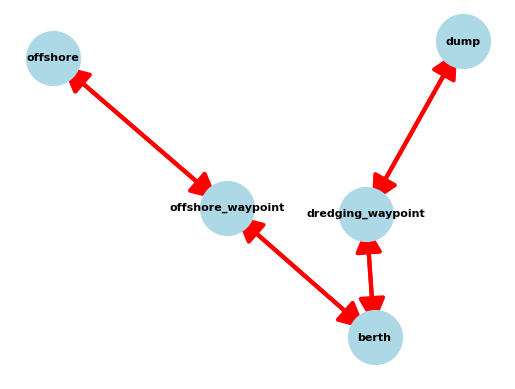

In [6]:
# we start with creating a graph 
graph = nx.DiGraph()

# a graph is initiated based on the name and gemometry of locations.
# other attributes such as store_capacity and initials are not being used for drawing the graph.
for node in nodes:
    graph.add_node(node.name,
                geometry = node.geometry)
     
# add edges
for index, edge in enumerate(edges):
    graph.add_edge(edge[0].name, edge[1].name, weight = 1)
    
# toggle to undirected and back to directed to make sure all edges are two way traffic
graph = graph.to_undirected() 
graph = graph.to_directed()

# create a positions dict for the purpose of plotting
positions = {}
for node in graph.nodes:
    positions[node] = (graph.nodes[node]['geometry'].x, graph.nodes[node]['geometry'].y)
    
# collect node labels.
labels = {}
for node in graph.nodes:
    labels[node] = node
print('Number of edges is {}'.format(len(graph.edges)))

# draw edges, nodes and labels.
nx.draw_networkx_edges(graph,  pos=positions, width=3, edge_color="red", alpha=1, arrowsize=40)
nx.draw_networkx_nodes(graph,  pos=positions, node_color="lightblue", node_size=1500)
nx.draw_networkx_labels(graph, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="black")

plt.axis("off")
plt.show()

##### 3.3. Create vessel object(s)

In [7]:
# assigning graph to the simpy environment
my_env.graph = graph

In [8]:
# define path for seagoing vessel
path1 = nx.dijkstra_path(my_env.graph, 'offshore', 'berth')
path2 = nx.dijkstra_path(my_env.graph, 'berth', 'offshore')
path_seagoing = path1+path2[1:]
display(path_seagoing)

# define path for dredging vessel
path3 = nx.dijkstra_path(my_env.graph, 'dump', 'berth')
path4 = nx.dijkstra_path(my_env.graph, 'berth', 'dump')
path_dredging = path3+path4[1:]
display(path_dredging)

['offshore', 'offshore_waypoint', 'berth', 'offshore_waypoint', 'offshore']

['dump', 'dredging_waypoint', 'berth', 'dredging_waypoint', 'dump']

In [9]:
# prepare input data for vessel_01 (dredging vessel)
data_vessel01 = {
    "env": my_env,
    "name": "dredging vessel",
    "geometry": location_dump, 
    "capacity": 10,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 10 + 2 * x,
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)
# assert not vessel01.metadata


# prepare input data for vessel_02 (seagoing vessel)
data_vessel02 = {
    "env": my_env,
    "name": "seagoing vessel",
    "geometry": location_offshore, 
    "capacity": 10,
    "level": 5,
    "loading_rate": 1,
    "unloading_rate": 0.5,
    "compute_v": lambda x: 15 + 2 * x,
}
# instantiate vessel_02
vessel02 = TransportProcessingResource(**data_vessel02)
assert not vessel02.metadata

##### 3.4. Create activity object(s)

In [10]:
# Initialise registry
registry = {}

In [11]:
# Specify the amount of container and duration of activities
amount = 10
duration = 200

# Specify dredging subprocesses
dredging_subprocesses = [
    model.MoveActivity(
        env=my_env,
        name="sailing empty dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=berth,
        ),
   model.ShiftAmountActivity(
        env=my_env,
        name="loading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=berth,
        destination=vessel01,
        amount=amount,
        duration=50*amount
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing full dredging vessel",
        registry=registry,
        mover=vessel01,
        destination=dump,
        ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading dredging vessel",
        registry=registry,
        processor=vessel01,
        origin=vessel01,
        destination=dump,
        amount=amount,
        duration=20*amount
        )
]

# Define activities of the dredging vessel
activities_dredging_vessel = model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential activity subcycle dredging vessel",
                registry=registry,
                sub_processes= dredging_subprocesses
            )],
             condition_event=[{"type": "container",
                              "concept": berth,
                              "state": "empty",
                              "id_":"default_reservations"}
                             ]
        )

In [12]:
# Specify seagoing subprocesses
requested_resources = {}
seagoing_subprocesses = [
    model.BasicActivity(
        env=my_env,
        name="interval time",
        registry=registry,
        duration=200
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing full seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=berth,
        ),
    model.ShiftAmountActivity(
        env=my_env,
        name="unloading seagoing vessel",
        registry=registry,
        processor=vessel02,
        origin=vessel02,
        destination=berth,
        amount=amount,
        duration=30*amount,
        requested_resources = requested_resources,
        ),
    model.MoveActivity(
        env=my_env,
        name="sailing empty seagoing vessel",
        registry=registry,
        mover=vessel02,
        destination=offshore,
        )
]

# Define activities of the seagoing vessel
activities_seagoing_vessel = model.WhileActivity(
            env=my_env,
            name="while sequential activity dredging vessel",
            registry=registry,
            sub_processes= seagoing_subprocesses,
            condition_event=[{"type": "container",
                              "concept": vessel02,
                              "state": "empty",
                              "id_":"default_reservations",
                              }
                             ]
        )

#### 4. Register activities and run simpy

In [13]:
# register dredging activities
model.register_processes([activities_dredging_vessel])

#register seagoing activities
model.register_processes([activities_seagoing_vessel])

In [14]:
my_env.run()

mover dredging vessel destination berth
mover seagoing vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
mover seagoing vessel destination offshore
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (3.637610458072877 52.10701582514347)
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geometry POINT (4.062705498083785 51.95909715255291)
mover dredging vessel destination dump
updating to destination geometry POINT (4.1795229742823 52.11590591837503)
mover dredging vessel destination berth
updating to destination geomet

#### 5. Inspect Results

##### 5.1. Inspect logs

In [15]:
# Inspect dredging vessel log
display(plot.get_log_dataframe(vessel01, [activities_dredging_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing empty dredging vessel,1970-01-01 00:00:00.000000,START,POINT (4.1795229742823 52.11590591837503),0.0
1,sailing empty dredging vessel,1970-01-01 00:32:00.113018,STOP,POINT (4.062705498083785 51.95909715255291),0.0
2,loading dredging vessel,1970-01-01 00:32:00.113018,START,POINT (4.062705498083785 51.95909715255291),0.0
3,loading dredging vessel,1970-01-01 00:40:20.113018,STOP,POINT (4.062705498083785 51.95909715255291),10.0
4,sailing full dredging vessel,1970-01-01 00:40:20.113018,START,POINT (4.062705498083785 51.95909715255291),10.0
...,...,...,...,...,...
67,loading dredging vessel,1970-01-01 10:03:01.770622,STOP,POINT (4.062705498083785 51.95909715255291),5.0
68,sailing full dredging vessel,1970-01-01 10:03:01.770622,START,POINT (4.062705498083785 51.95909715255291),5.0
69,sailing full dredging vessel,1970-01-01 10:32:07.327912,STOP,POINT (4.1795229742823 52.11590591837503),5.0
70,unloading dredging vessel,1970-01-01 10:32:07.327912,START,POINT (4.1795229742823 52.11590591837503),5.0


In [16]:
# Inspect seagoing vessel log
display(plot.get_log_dataframe(vessel02, [activities_seagoing_vessel]))

,Activity,Timestamp,ActivityState,geometry,container level
0,sailing full seagoing vessel,1970-01-01 00:03:20.000000,START,POINT (3.637610458072877 52.10701582514347),5
1,sailing full seagoing vessel,1970-01-01 00:38:13.474629,STOP,POINT (4.062705498083785 51.95909715255291),5
2,unloading seagoing vessel,1970-01-01 00:40:20.113018,START,POINT (4.062705498083785 51.95909715255291),5
3,unloading seagoing vessel,1970-01-01 00:45:20.113018,STOP,POINT (4.062705498083785 51.95909715255291),0
4,sailing empty seagoing vessel,1970-01-01 00:45:20.113018,START,POINT (4.062705498083785 51.95909715255291),0
5,sailing empty seagoing vessel,1970-01-01 01:22:33.152622,STOP,POINT (3.637610458072877 52.10701582514347),0


##### 5.2. Visualise gantt chart

In [17]:
plot.get_gantt_chart([vessel01,vessel02], id_map=[activities_dredging_vessel, activities_seagoing_vessel])

##### 5.3 Visualise container volume developments

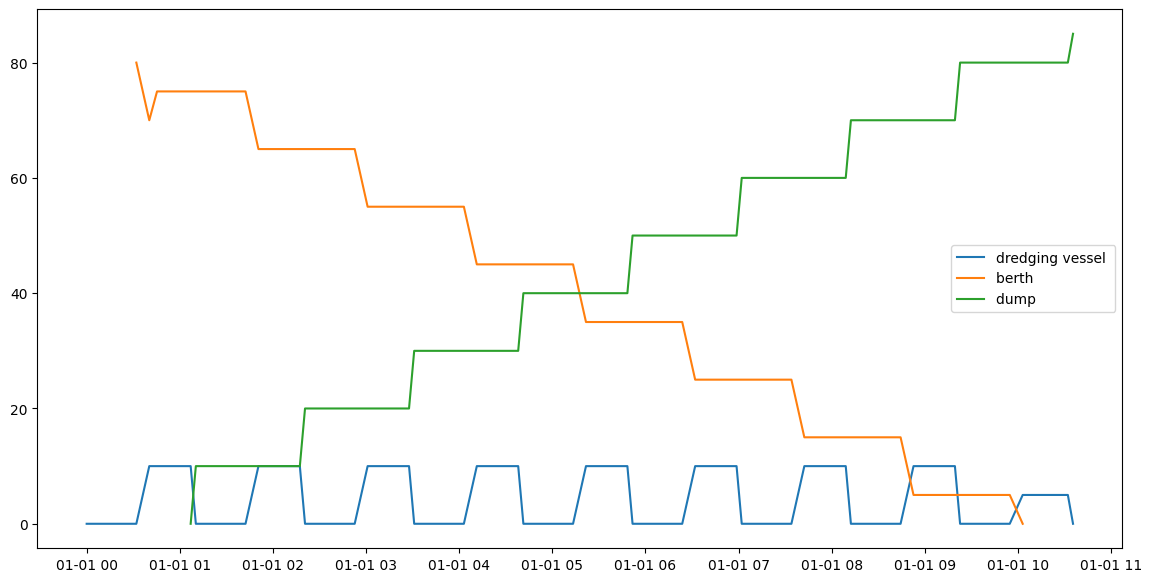

In [18]:
fig = plot.get_step_chart([vessel01, berth, dump])

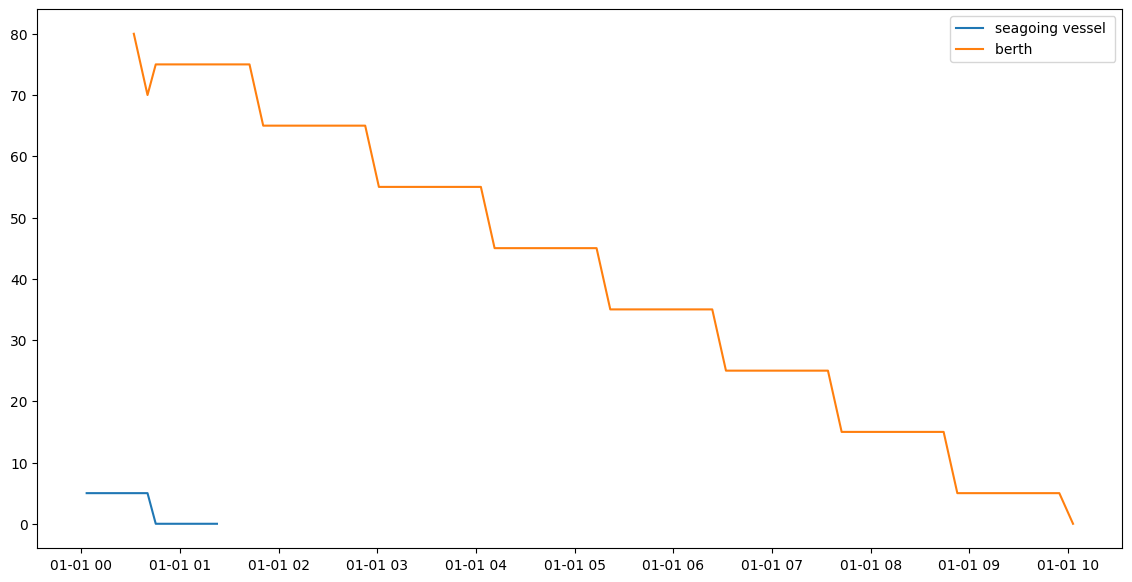

In [19]:
fig = plot.get_step_chart([vessel02, berth, offshore])